In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
def load_processed_data(train_path='../../data/processed/train_data_weather.csv',
                       test_path='../../data/processed/test_data_weather.csv'):
    """Load preprocessed training and test datasets with weather features"""
    train = pd.read_csv(train_path, parse_dates=['Datetime'])
    test = pd.read_csv(test_path, parse_dates=['Datetime'])
    return train, test

# Load the data
train_data, test_data = load_processed_data()

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nFeatures available:", [col for col in train_data.columns if col not in ['Datetime', 'PJME', 'timeofday']])

Training data shape: (114565, 86)
Test data shape: (28642, 86)

Features available: ['PJMW', 'avg_wind_speed', 'precipitation', 'avg_temperature', 'max_temperature', 'min_temperature', 'temperature', 'avg_wind_speed_chicago', 'precipitation_chicago', 'avg_temperature_chicago', 'max_temperature_chicago', 'min_temperature_chicago', 'temperature_chicago', 'avg_wind_speed_washington', 'precipitation_washington', 'avg_temperature_washington', 'max_temperature_washington', 'min_temperature_washington', 'temperature_washington', 'avg_wind_speed_pittsburgh', 'precipitation_pittsburgh', 'avg_temperature_pittsburgh', 'max_temperature_pittsburgh', 'min_temperature_pittsburgh', 'temperature_pittsburgh', 'avg_wind_speed_columbus', 'precipitation_columbus', 'avg_temperature_columbus', 'max_temperature_columbus', 'min_temperature_columbus', 'temperature_columbus', 'regional_temp_mean', 'regional_temp_std', 'regional_wind_mean', 'regional_wind_std', 'regional_precip_mean', 'regional_precip_std', 'temp

In [3]:
def prepare_features(data):
    """Prepare features for ML models"""
    feature_cols = [col for col in data.columns 
                   if col not in ['Datetime', 'PJME', 'timeofday']]
    X = data[feature_cols]
    y = data['PJME']
    return X, y

X_train, y_train = prepare_features(train_data)
X_test, y_test = prepare_features(test_data)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (114565, 83)
Testing features shape: (28642, 83)


Top 10 correlated features with energy consumption:
                                 feature  correlation
PJME_lag_1h                  PJME_lag_1h     0.969859
PJME_lag_24h                PJME_lag_24h     0.892211
PJMW                                PJMW     0.875861
PJME_lag_168h              PJME_lag_168h     0.789476
PJME_lag_48h                PJME_lag_48h     0.772693
PJME_roll_24h_mean    PJME_roll_24h_mean     0.669316
PJME_roll_168h_mean  PJME_roll_168h_mean     0.562390
hour                                hour     0.494875
PJME_roll_24h_std      PJME_roll_24h_std     0.386511
PJME_roll_168h_std    PJME_roll_168h_std     0.362465


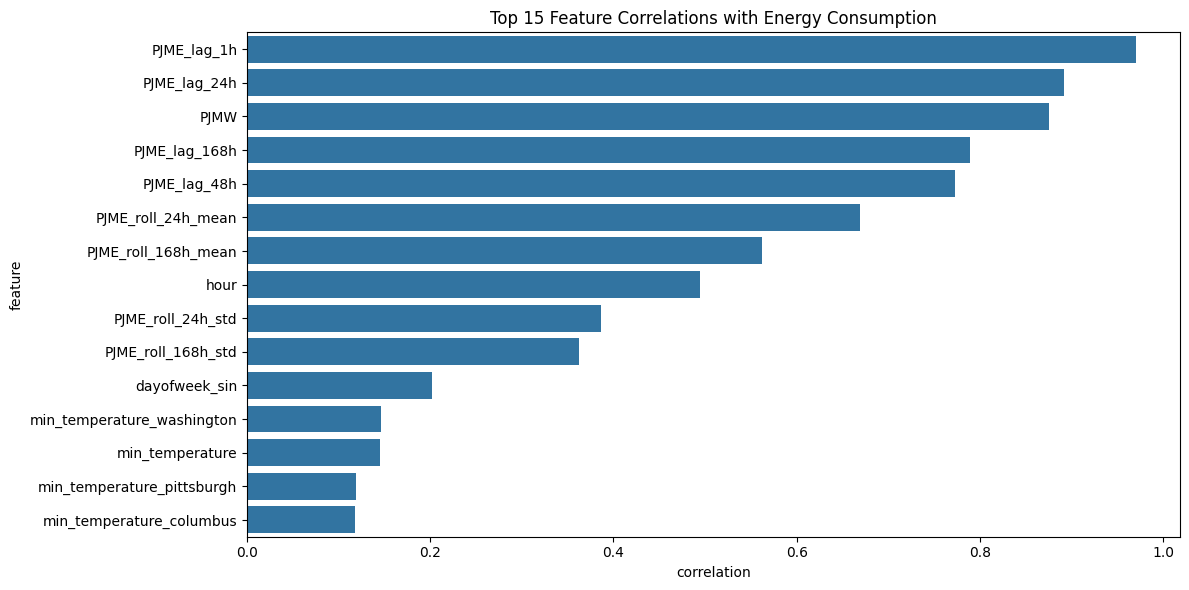

In [4]:
# Calculate correlations with target
correlations = pd.DataFrame({'feature': X_train.columns,
                           'correlation': X_train.corrwith(y_train)})
correlations = correlations.sort_values('correlation', ascending=False)

print("Top 10 correlated features with energy consumption:")
print(correlations.head(10))

# Visualize correlations
plt.figure(figsize=(12, 6))
sns.barplot(x='correlation', y='feature', data=correlations.head(15))
plt.title('Top 15 Feature Correlations with Energy Consumption')
plt.tight_layout()
plt.show()


Random Forest Metrics:
RMSE    500.545023
MAE     333.893919
R2        0.994110
MAPE      1.062433
dtype: float64


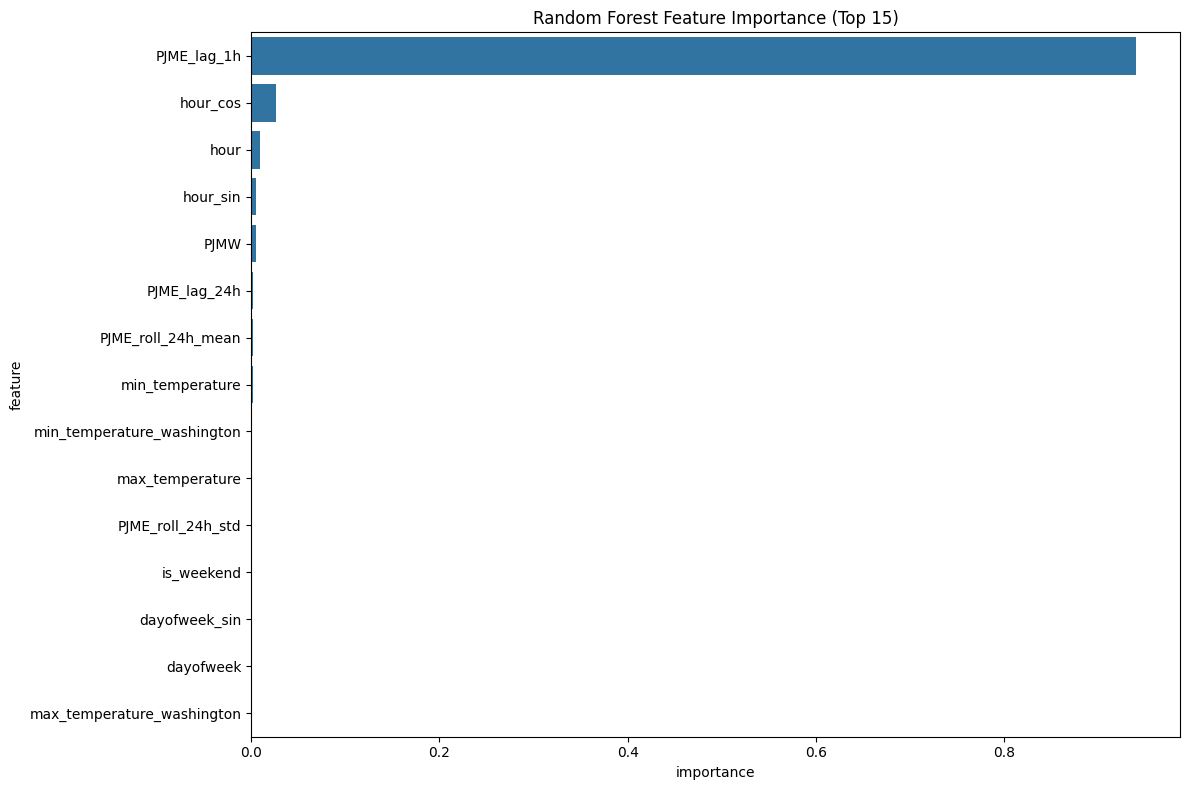

In [6]:
def train_random_forest(X_train, y_train, X_test, y_test):
    """Train and evaluate Random Forest model"""
    # Initialize model
    rf = RandomForestRegressor(n_estimators=200,
                              max_depth=30,
                              min_samples_split=5,
                              min_samples_leaf=2,
                              random_state=42,
                              n_jobs=-1)
    
    # Train and predict
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    }
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return rf, metrics, importance

# Train Random Forest
rf_model, rf_metrics, rf_importance = train_random_forest(X_train, y_train,
                                                        X_test, y_test)

print("Random Forest Metrics:")
print(pd.Series(rf_metrics))

# Plot RF feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=rf_importance.head(15))
plt.title('Random Forest Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

XGBoost Metrics:
RMSE    493.860603
MAE     349.472593
R2        0.994266
MAPE      1.118462
dtype: float64


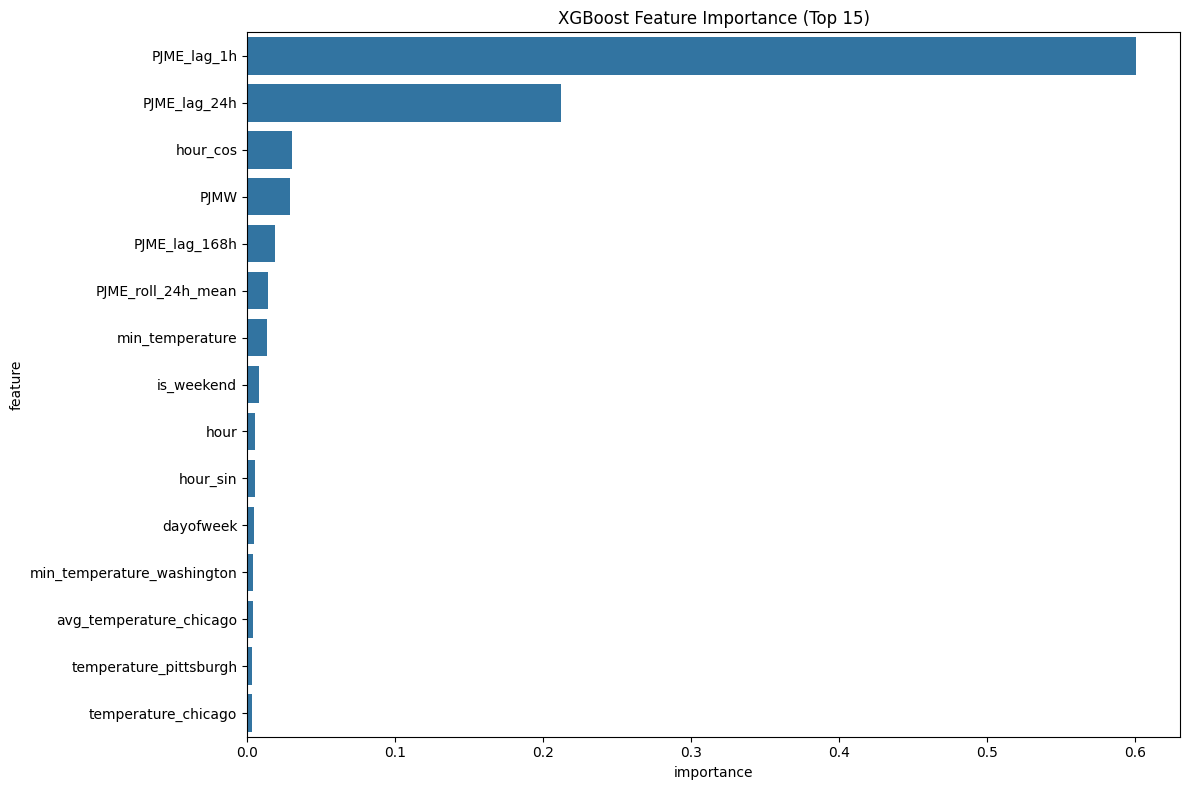

In [7]:
def train_xgboost(X_train, y_train, X_test, y_test):
    """Train and evaluate XGBoost model"""
    # Initialize model
    xgb = XGBRegressor(n_estimators=200,
                       max_depth=10,
                       learning_rate=0.05,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       random_state=42)
    
    # Train and predict
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    }
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return xgb, metrics, importance

# Train XGBoost
xgb_model, xgb_metrics, xgb_importance = train_xgboost(X_train, y_train,
                                                      X_test, y_test)

print("XGBoost Metrics:")
print(pd.Series(xgb_metrics))

# Plot XGB feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=xgb_importance.head(15))
plt.title('XGBoost Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

Analyzing Random Forest weather impact...


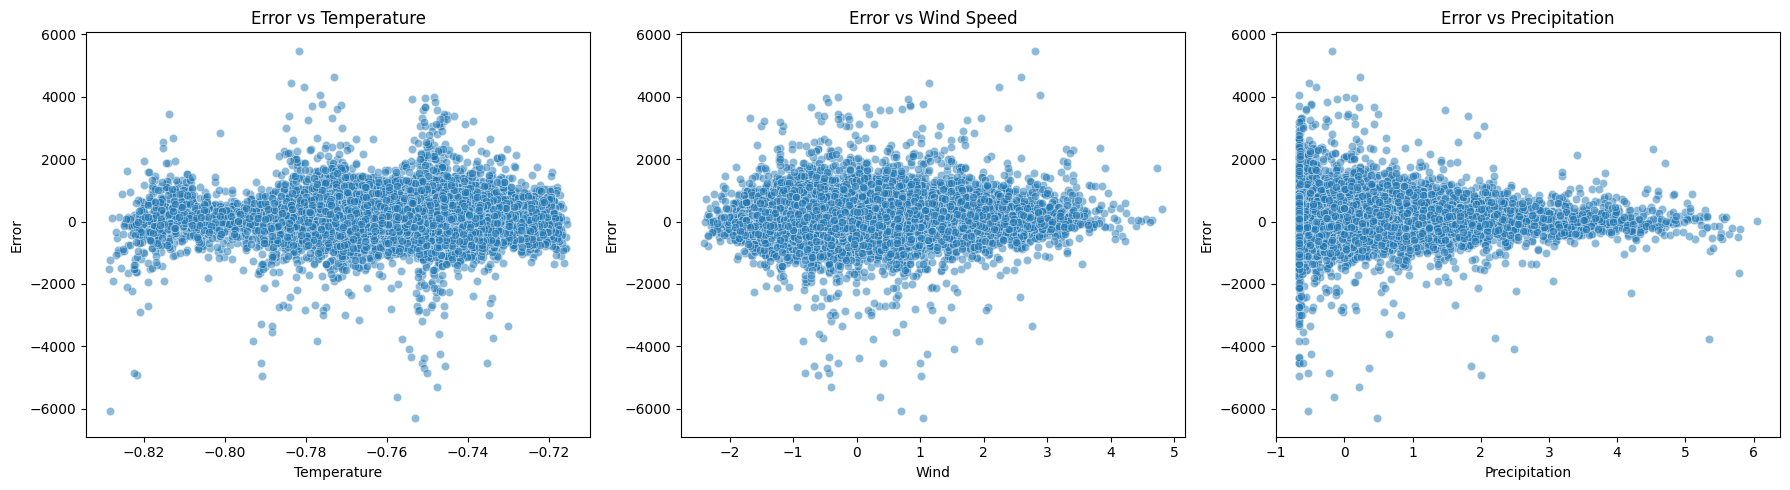


Analyzing XGBoost weather impact...


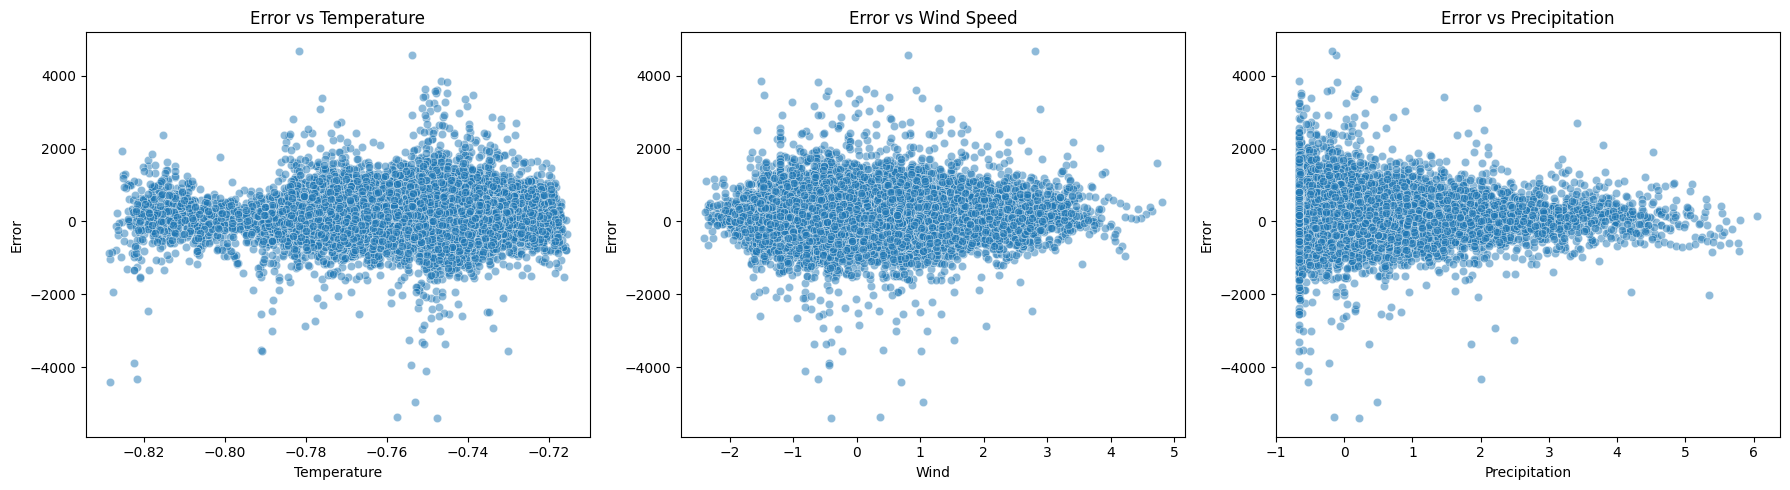

In [8]:
def analyze_weather_impact(model, X_test, y_test):
    """Analyze prediction errors vs weather conditions"""
    # Make predictions
    y_pred = model.predict(X_test)
    errors = y_pred - y_test
    
    # Create analysis dataframe
    weather_features = ['regional_temp_mean', 'regional_wind_mean', 
                       'regional_precip_mean']
    analysis_df = pd.DataFrame({
        'Error': errors,
        'Temperature': X_test['regional_temp_mean'],
        'Wind': X_test['regional_wind_mean'],
        'Precipitation': X_test['regional_precip_mean']
    })
    
    # Plot relationships
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.scatterplot(data=analysis_df, x='Temperature', y='Error', ax=axes[0], alpha=0.5)
    sns.scatterplot(data=analysis_df, x='Wind', y='Error', ax=axes[1], alpha=0.5)
    sns.scatterplot(data=analysis_df, x='Precipitation', y='Error', ax=axes[2], alpha=0.5)
    
    axes[0].set_title('Error vs Temperature')
    axes[1].set_title('Error vs Wind Speed')
    axes[2].set_title('Error vs Precipitation')
    
    plt.tight_layout()
    plt.show()
    
    return analysis_df

# Analyze weather impact for both models
print("Analyzing Random Forest weather impact...")
rf_weather_analysis = analyze_weather_impact(rf_model, X_test, y_test)

print("\nAnalyzing XGBoost weather impact...")
xgb_weather_analysis = analyze_weather_impact(xgb_model, X_test, y_test)

In [9]:
# Compare model performance
comparison = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
})

print("Model Comparison:")
print(comparison)

Model Comparison:
      Random Forest     XGBoost
RMSE     500.545023  493.860603
MAE      333.893919  349.472593
R2         0.994110    0.994266
MAPE       1.062433    1.118462


In [11]:
# Save models and results
import joblib
joblib.dump(rf_model, '../models/random_forest_weather.joblib')
joblib.dump(xgb_model, '../models/xgboost_weather.joblib')
comparison.to_csv('../results/model_comparison_weather.csv')

print("\nModels and results saved successfully")


Models and results saved successfully
